In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from ipywidgets import widgets
import ConfigReader as cr

/home/mendozah/workspace/envHDMp/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
idx = pd.IndexSlice

#Styles
sns.set_style('darkgrid')
sns.set_color_codes()
plt.rcParams['figure.figsize'] = (12.0, 9.0)

plt.rc('text', usetex=False)
plt.rc('font', size=20.0, family='serif')

In [355]:
# Data location and scenario
data_dir = '/mhome/mendozah/autonet_0305_benchmark/results/experiment'
dataset = '917_bac'
preprocessor='all'
fline = 'validationResults-detailed-traj-run-30-walltime.csv'
traj_file = os.path.join(data_dir, dataset, preprocessor, dataset, fline)

In [478]:
reader = cr.ConfigReader(data_dir=data_dir, dataset=dataset)
tdf = reader.load_validation_trajectories(preprocessor=preprocessor, load_config=True)

In [497]:
tdf.loc[:, ('classifier','num_layers')] = tdf['classifier']['num_layers'].apply(lambda X:ord(X)-ord('a'))

In [443]:
# Start filtering the error
temp_df = tdf.copy()
temp_df.columns = tdf.columns.droplevel(0)

In [444]:
min_perf = temp_df['test_performance'].min()
mean_perf = temp_df['test_performance'].mean()
std_perf = temp_df['test_performance'].std()

In [456]:
m = tdf[('smac', 'test_performance')] <= mean_perf
#tdf[m]

### Setting values to log scale and categorical values

In [457]:
log_columns = ['beta1', 'beta2', 'gamma', 'lambda2', 'learning_rate', 'momentum','num_units_layer_1',
               'num_units_layer_2', 'num_units_layer_3', 'num_units_layer_4', 'num_units_layer_5',
               'num_units_layer_6', 'power', 'std_layer_1', 'std_layer_2', 'std_layer_3','std_layer_4',
               'std_layer_5', 'std_layer_6']

categorical_cols = ['activation_layer_1', 'activation_layer_2', 'activation_layer_3', 'activation_layer_4',
                    'activation_layer_5', 'activation_layer_6', 'lr_policy', 'num_layers', 'weight_init_1',
                    'weight_init_2', 'weight_init_3', 'weight_init_4', 'weight_init_5', 'weight_init_6']

In [480]:
for lc in log_columns:
    try:
        tdf.loc[:, ('classifier', lc)] = np.log10(tdf.loc[:, ('classifier', lc)])
    except KeyError:
        continue

In [525]:
for cc in categorical_cols:
    try:
        tdf.loc[:, ('classifier',cc)] = tdf.loc[:, ('classifier',cc)].astype('category')
    except KeyError:
        continue

## After Setting the frames. Start with the plotting

In [395]:
# Plot the empirical CDF
sorted_train = (tdf.sort_values(by=('smac','train_performance'), ascending=True).loc[:,('smac','train_performance')].values)
sorted_test  = (tdf.sort_values(by=('smac','test_performance'), ascending=True).loc[:,('smac','test_performance')].values)
ytrain = np.arange(len(sorted_train)) / float(len(sorted_train))
ytest = np.arange(len(sorted_test)) / float(len(sorted_test))

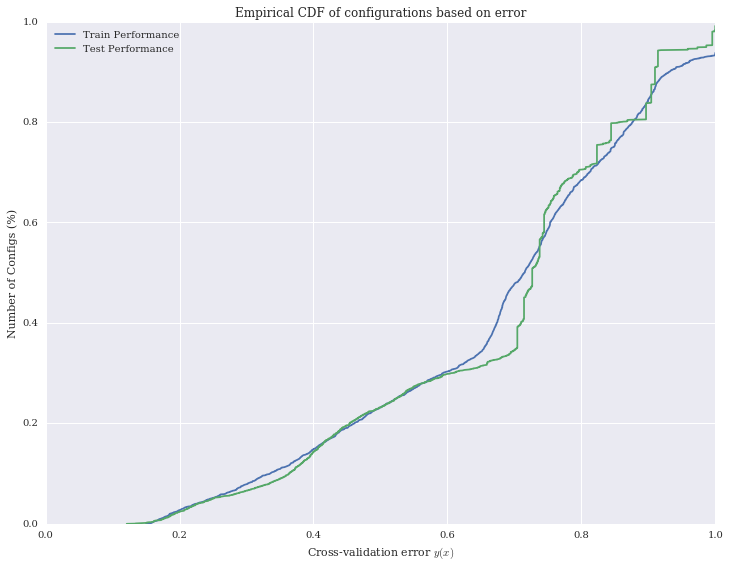

In [399]:
plt.plot(sorted_train, ytrain, label="Train Performance")
plt.plot(sorted_test, ytest, label="Test Performance")
plt.xlabel("Cross-validation error $y(x)$")
plt.ylabel(r"Number of Configs (%)")
plt.xlim(0.0, min(1.0, sorted_train.max()))
plt.title("Empirical CDF of configurations based on error")
plt.legend(loc='best')
plt.show()

In [244]:
def plotting_threshold(error_threshold, categories):
    mask_filter = tdf[('smac','test_performance')] <= error_threshold
    filtered = tdf[mask_filter]
    fig_f, axs = plt.subplots(ncols=2,nrows=1, figsize=(15.0, 8.5))
    ax0, ax1 = axs.flat
    sns.boxplot(x=categories, y=('smac','test_performance'), data=filtered, ax=ax0)
    sns.countplot(y=categories, data=filtered, ax=ax1)
    fig_f.tight_layout()

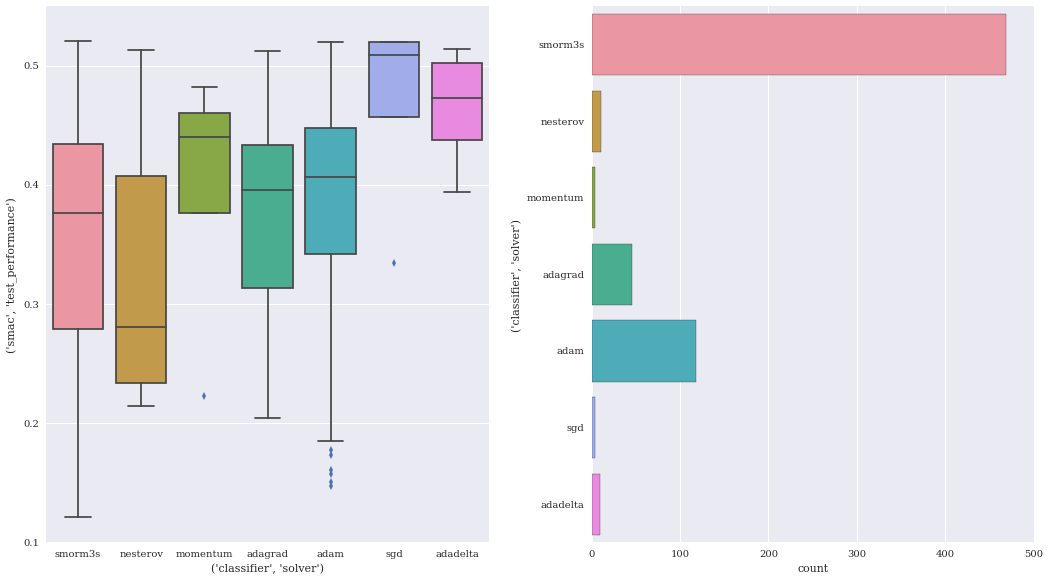

In [508]:
widgets.interact(plotting_threshold, error_threshold=(min_perf,mean_perf + std_perf, 0.01),
                 categories={'Solver':('classifier','solver'), 'Policy':('classifier','lr_policy'),
                             'Number of layers':('classifier','num_layers')})

### Plot distro over learning rates

In [372]:
# Create the grouping of the filtered DF
classifier_df = tdf[m]['classifier']
solver_filt = classifier_df.groupby('solver')

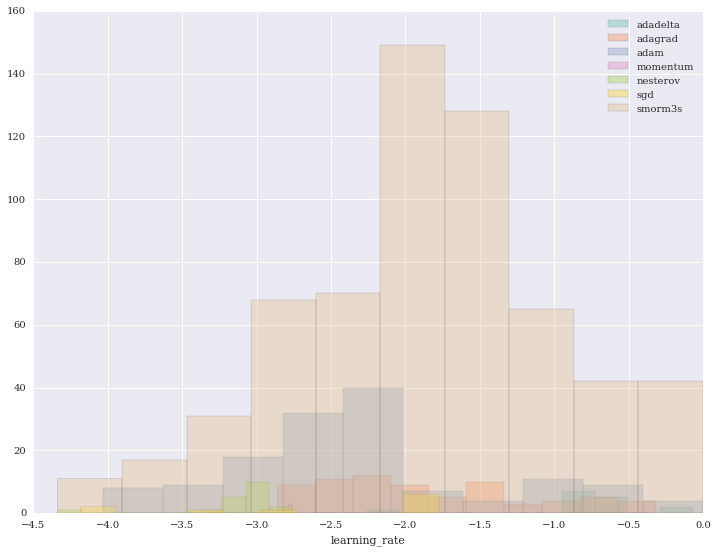

In [496]:
# Seaborns Normed Distribution plots
with sns.color_palette('Set2',8):
    for name,groups in solver_filt:
        #sns.distplot(groups.learning_rate, bins=6, kde_kws={'label':name, 'bw':0.019})
        sns.distplot(groups.learning_rate, kde=False, bins=10, hist_kws={'label':name}, norm_hist=False)
        #plt.hist(groups.learning_rate.values, alpha=0.8, bins=20, label=name)
    plt.legend()

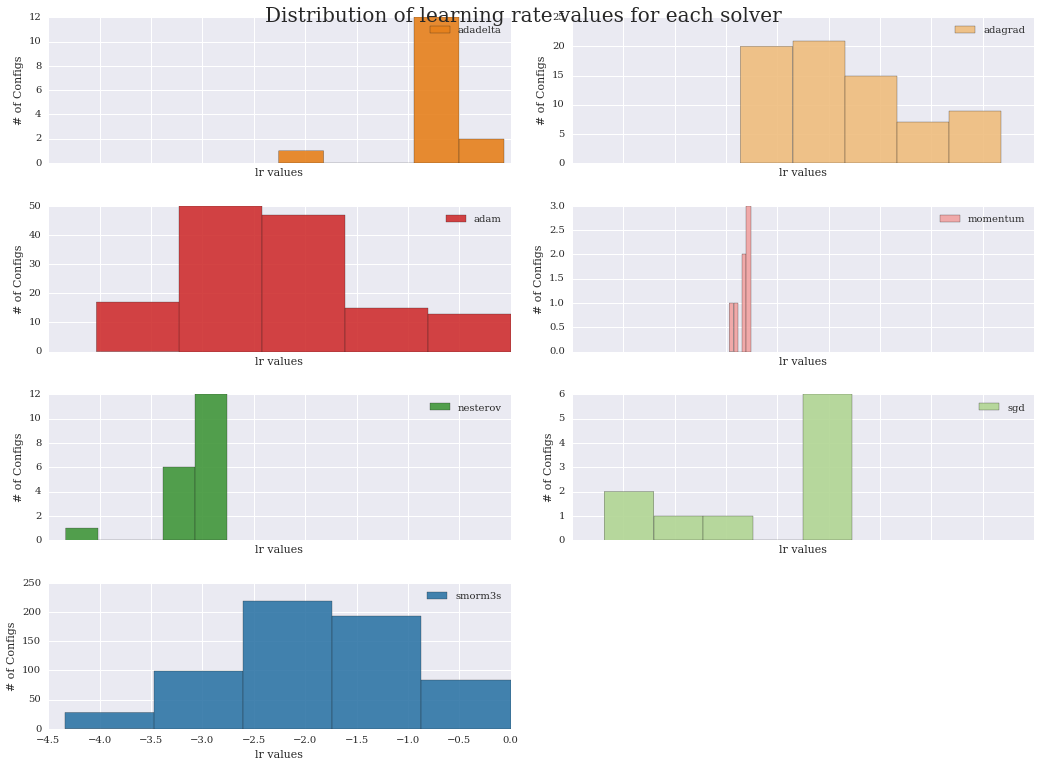

In [511]:
col_hist = sns.color_palette('Paired',8, desat=0.8)
fig2, axs = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(15.,11.))
fig2.suptitle('Distribution of learning rate values for each solver')
for ax, (name, groups) in zip(axs.flat,solver_filt):
    ax.hist(groups.learning_rate.values, bins=5, histtype='bar', fill=True,
            label=name, alpha=0.9, color=col_hist.pop())
    ax.set_xlabel('lr values')
    ax.set_ylabel('# of Configs')
    ax.legend()
plt.tight_layout()
ax = axs.flat[-1]
ax.set_visible(False)


### Plot over different preprocessing methods

In [486]:
# Create the grouping of the filtered DF
prepro_filt = tdf[m].groupby([('preprocessor','choice')])

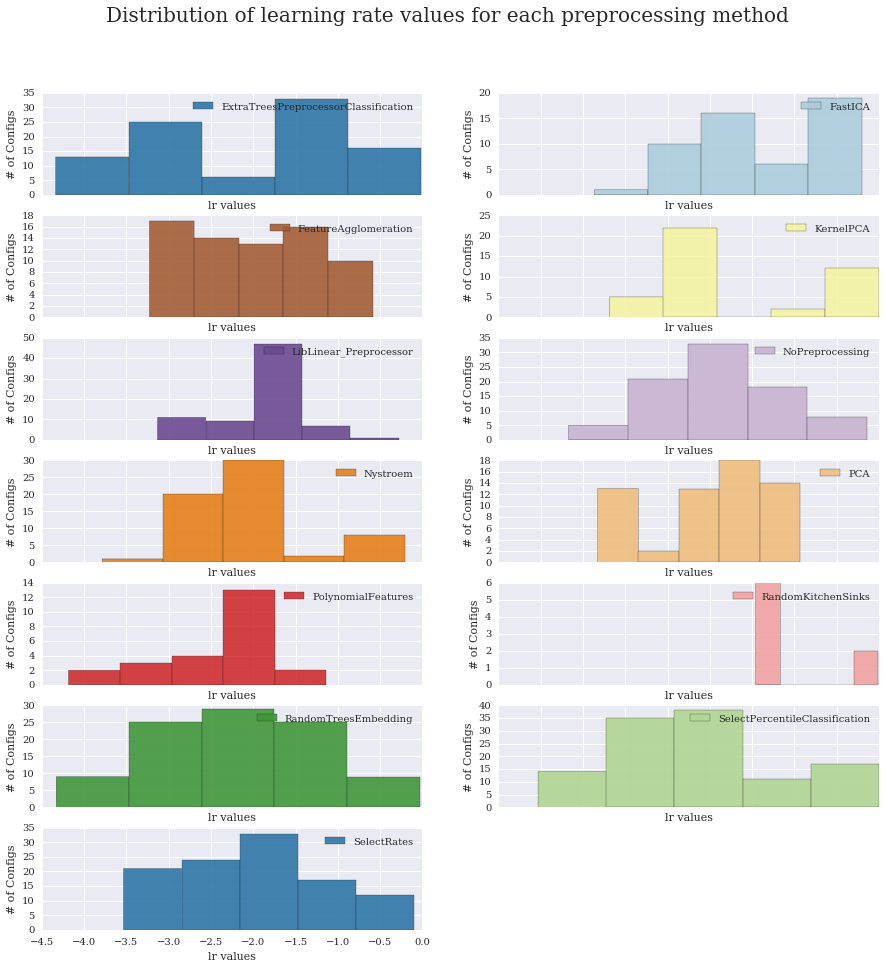

In [502]:
prepro_color = sns.color_palette('Paired',14, desat=0.8)

fig4, axs = plt.subplots(nrows=7, ncols=2, sharex='col', figsize=(15.,15.))
fig4.suptitle('Distribution of learning rate values for each preprocessing method')
for ax, (name, grops) in zip(axs.flat,prepro_filt):
    groups = grops['classifier']
    ax.hist(groups.learning_rate.values, bins=5, histtype='bar', fill=True, label=name,
            alpha=0.9, color=prepro_color.pop())
    ax.set_xlabel('lr values')
    ax.set_ylabel('# of Configs')
    ax.legend()
ax = axs.flat[-1]
ax.set_visible(False)

### Plot over different solver

In [424]:
def histogram_group_column_plotting(grouping, column):
    g = classifier_df.groupby(grouping)
    s = len(g)
    col_hist = sns.color_palette('Paired',s, desat=0.8)
    fig_hist, axs = plt.subplots(nrows=int(np.ceil(s/2.)), ncols=2, sharex='col',
                                 figsize=(15., 11.))
    for ax, (name, groups) in zip(axs.flat, g):
        ax.hist(groups[column].dropna().values, bins=15,
                histtype='bar', fill=True, label=name, alpha=0.9, color=col_hist.pop())
        ax.set_xlabel(column + ' values')
        ax.set_ylabel('# of Configs')
        ax.legend()
    ax = axs.flat[7]
    ax.set_visible(False)
    fig_hist.suptitle('Distribution of '+ column +' values for each '+(grouping))

In [422]:
# Create columns dict
Groups = ['solver', 'lr_policy']
Plott = {'# of Epochs':'number_updates', 'batch size':'batch_size',
         'step (lr_policy)':'epoch_step', 'Gamma':'gamma', 'Lambda':'lambda2', 'learning rate': 'learning_rate',
         'Beta 1':'beta1', 'Beta 2':'beta2', 'Momentum':'momentum', 'Rho':'rho', 'Power':'power',
         'Dropout rate of layer 1':'dropout_layer_1', 'Dropout rate of layer 2':'dropout_layer_2',
         'Dropout rate of layer 3':'dropout_layer_3', 'Dropout rate of layer 4':'dropout_layer_4',
         'Dropout rate of layer 5':'dropout_layer_5', 'Dropout rate at output':'dropout_output'}

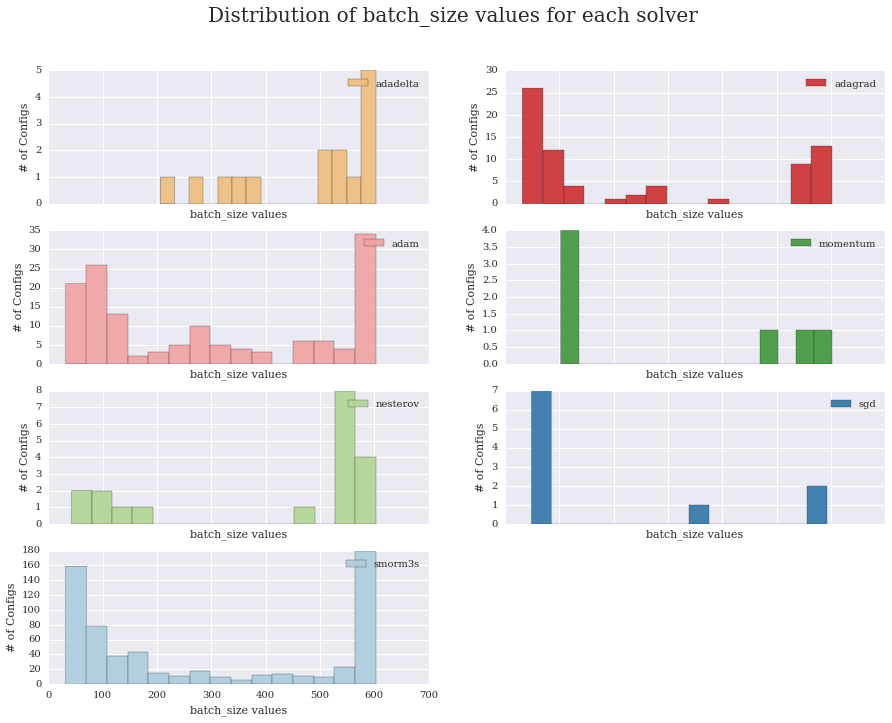

In [425]:
widgets.interact(histogram_group_column_plotting, grouping=Groups, column=Plott)

### Distribution of each parameter over all filtered configurations

In [490]:
def histogram_column_plotting(column):
    #Have to convert the -1 to NaN
    fig_hist = plt.figure(6)
    ax1 = plt.subplot(111)
    ax1.set_title('Histogram of '+column)
    classifier_df[column].plot(kind='hist', bins=15, ax=ax1)
    ax1.set_xlabel('values')

In [491]:
non_cat_cols = [item for item in classifier_df.columns.values if item not in categorical_cols]

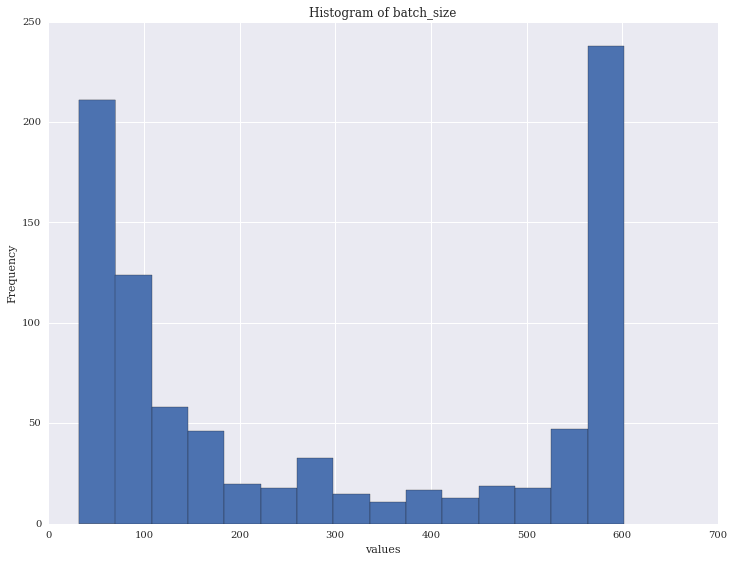

In [492]:
widgets.interact(histogram_column_plotting, column=non_cat_cols)

## Plot average best architectures

In [526]:
top5 = tdf.sort_values([('smac','test_performance')]).head(5)

In [531]:
top5

balancing         classifier                                        \
       strategy activation_layer_1 activation_layer_2 activation_layer_3   
108        none            sigmoid             linear                NaN   
2593  weighting            sigmoid                NaN                NaN   
110        none            sigmoid             linear                NaN   
2596  weighting               relu                NaN                NaN   
2351  weighting               relu                NaN                NaN   

                                                                          \
     activation_layer_4 activation_layer_5 activation_layer_6 batch_size   
108                 NaN                NaN                NaN        230   
2593                NaN                NaN                NaN         38   
110                 NaN                NaN                NaN        230   
2596                NaN                NaN                NaN         38   
2351                NaN                NaN                NaN        602   

                                ...        preprocessor               \
         beta1     beta2        ...          percentile pooling_func   
108        NaN       NaN        ...                 NaN          NaN   
2593       NaN       NaN        ...                 NaN          NaN   
110        NaN       NaN        ...                 NaN          NaN   
2596       NaN       NaN        ...                 NaN          NaN   
2351 -1.450877 -1.838159        ...           15.016892          NaN   

                              rescaling      smac                              \
     score_func tol whiten       choice config_ID test_performance       time   
108         NaN NaN    NaN  standardize        13         0.121111  19328.808   
2593  f_classif NaN    NaN  standardize        11         0.133333  15965.613   
110         NaN NaN    NaN  standardize        15         0.134444  21679.231   
2596  f_classif NaN    NaN  standardize        14         0.140000  22099.097   
2351  f_classif NaN    NaN  standardize        16         0.147778  62029.868   

                        
     train_performance  
108           0.197691  
2593          0.177896  
110           0.181698  
2596          0.151016  
2351          0.167503  

[5 rows x 109 columns]

In [529]:
top5['classifier']['num_layers']

108     3
2593    2
110     3
2596    2
2351    2
Name: num_layers, dtype: category
Categories (6, int64): [2, 3, 4, 5, 6, 7]

In [524]:
top5['classifier']['activation_layer_1']

108     sigmoid
2593    sigmoid
110     sigmoid
2596       relu
2351       relu
Name: activation_layer_1, dtype: object

In [536]:
top5['classifier']['activation_layer_2']

108     linear
2593       NaN
110     linear
2596       NaN
2351       NaN
Name: activation_layer_2, dtype: category
Categories (7, object): [elu, leaky, linear, relu, scaledTanh, sigmoid, tanh]

In [534]:
top5['classifier']['num_units_layer_1']

108     2.376577
2593    1.851258
110     2.376577
2596    1.986772
2351    3.219585
Name: num_units_layer_1, dtype: float64

In [530]:
top5['classifier']['weight_init_1']

108      glorot_normal
2593         he_normal
110            uniform
2596         he_normal
2351    glorot_uniform
Name: weight_init_1, dtype: category
Categories (9, object): [constant, glorot_normal, glorot_uniform, he_normal, ..., normal, ortogonal, sparse, uniform]

In [542]:
top5['classifier']['weight_init_2'].

count              2
unique             1
top       he_uniform
freq               2
Name: weight_init_2, dtype: object

In [535]:
top5['classifier']['num_units_layer_2']

108     2.307496
2593         NaN
110     2.307496
2596         NaN
2351         NaN
Name: num_units_layer_2, dtype: float64

In [538]:
top5['preprocessor']['choice']

108     ExtraTreesPreprocessorClassification
2593                             SelectRates
110     ExtraTreesPreprocessorClassification
2596                             SelectRates
2351          SelectPercentileClassification
Name: choice, dtype: object